In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
# # DELETE THIS EVENTUALLY
# def clones(module, N):
#     "Produce N identical layers."
#     return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# Attention

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, masked=False):
        super(MultiHeadAttention, self).__init__()

        self.masked = masked
        self.attentionHeads = nn.ModuleList([SingleHeadAttention(masked) for _ in range(n_heads)])
        self.linear = nn.Linear(ATTENTION_CONST['mh_concat_width'], ATTENTION_CONST['mh_output_width'])
        self.lastHeadKV = None

    def forward(self, inputs, encoderKV=None):
        x = []
        for head in self.attentionHeads:
            sh_attention, k, v = head(inputs, encoderKV=encoderKV) 
            x.append(sh_attention)
        self.lastHeadKV = {'K': k,'V': v}
        x = torch.cat(x, 1) # concatinate all single head attention outputs
        x = self.linear(x) # matmul with weight matrix (linear layer) to get 10x64 shape
        return x

class SingleHeadAttention(nn.Module):
    def __init__(self, masked):
        super(SingleHeadAttention, self).__init__()
        self.masked = masked
        self.linear1 = nn.Linear(ATTENTION_CONST['sh_linear1_input'], ATTENTION_CONST['sh_linear1_output'])
        self.linear2 = nn.Linear(ATTENTION_CONST['sh_linear2_input'], ATTENTION_CONST['sh_linear2_output'])
        self.linear3 = nn.Linear(ATTENTION_CONST['sh_linear3_input'], ATTENTION_CONST['sh_linear3_output'])
        self.scale = nn.Parameter(torch.FloatTensor([ATTENTION_CONST['sh_scale_factor']]))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs, encoderKV=None):        
        q = self.linear1(inputs)
        k = self.linear2(inputs) if encoderKV == None else encoderKV['K']
        v = self.linear3(inputs) if encoderKV == None else encoderKV['V']
        x = torch.matmul(q, k.permute(1, 0)) 
        x = x * self.scale
        # if self.masked:
        #     # TODO "future positions" have to be set to -inf. this is for the decoder to only allow self attention to consider earlier positions.
        x = self.softmax(x) 
        x = torch.matmul(x, v)
        return x if encoderKV != None else x, k, v


In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads):
        super(MultiHeadAttention, self).__init__()

        self.linear = nn.Linear(64, 512)
        self.wQ = nn.Linear(512, 64)
        self.wK = nn.Linear(512, 64)
        self.wV = nn.Linear(512, 64)

    def forward(self, q, k, v):
        q = self.wQ(q)
        k = self.wK(k)
        v = self.wV(v)

        # split heads - I think they do this instead of a loop
        x, attention_weights = self.applyHeads(q, k, v)
        # transpose ?
        # reshape ?
        x = self.linear(x)
        return x, attention_weights

    def applyHeads(self, q, k, v, mask=None):
        x = torch.matmul(q, k.permute(1, 0)) 
        # scale x
        # add mask
        attention_weights = nn.Softmax(dim=-1)(x)
        x = torch.matmul(attention_weights, v)
        return x, attention_weights



In [6]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model=512, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = nn.ModuleList([copy.deepcopy(nn.Linear(d_model, d_model)) for _ in range(4)])
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

# Encoder

In [8]:
class Encoder(nn.Module):
    def __init__(self, n_layers, n_heads):
        super(Encoder, self).__init__()
        
        self.encoderLayers = nn.ModuleList([EncoderLayer(n_heads) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(512)

    def forward(self, inputs, mask):
        x = inputs

        for layer in self.encoderLayers:
            x = layer(x, mask)
        x = self.norm(x)
        return x
    
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, dropout=0.1):
        super(EncoderLayer, self).__init__()

        self.mhattention = MultiHeadAttention(n_heads)
        self.norm1 = nn.LayerNorm(512)
        self.norm2 = nn.LayerNorm(512)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.feedforward = PositionwiseFeedForward(512, 2048)

    def forward(self, inputs, mask):
        x = inputs 
        z = x
        x = self.mhattention(x, x, x, mask)
        x = self.dropout1(x)
        x = z + x
        x = self.norm1(x)
        z = x
        x = self.feedforward(x)
        x = self.dropout2(x)
        x = z + x
        x = self.norm2(x) 
        return x

# Decoder

In [9]:
class Decoder(nn.Module):
    def __init__(self, n_layers, n_heads):
        super(Decoder, self).__init__()
        
        self.decoderLayers = nn.ModuleList([DecoderLayer(n_heads) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(512)

    def forward(self, inputs, encoderOut, src_mask, tgt_mask):
        x = inputs

        for layer in self.decoderLayers:
            x = layer(x, encoderOut, src_mask, tgt_mask) 

        return x

class DecoderLayer(nn.Module):
    def __init__(self, n_heads, dropout=0.1):
        super(DecoderLayer, self).__init__()

        self.mhattention1 = MultiHeadAttention(n_heads)
        self.mhattention2 = MultiHeadAttention(n_heads)
        self.norm1 = nn.LayerNorm(512)
        self.norm2 = nn.LayerNorm(512)
        self.norm3 = nn.LayerNorm(512)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.feedforward = PositionwiseFeedForward(512, 2048)

    def forward(self, inputs, encoderOut, src_mask, tgt_mask):
        x = inputs
        z = x
        x = self.mhattention1(x, x, x, tgt_mask)
        x = self.dropout1(x)
        x = z + x        
        x = self.norm1(x)
        z = x
        x = self.mhattention2(x, encoderOut, encoderOut, src_mask) 
        x = self.dropout2(x)
        x = z + x
        x = self.norm2(x)
        z = x
        x = self.feedforward(x)
        x = self.dropout3(x)
        x = z + x
        x = self.norm3(x)
        return x

# Position-wise feed forward

In [10]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, dim_model, dim_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(dim_model, dim_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_ff, dim_model)

    def forward(self, inputs):
        x = inputs
        x = self.linear1(x)
        x = nn.functional.relu(x) 
        x = self.dropout(x) 
        x = self.linear2(x) 
        return x


# Embeddings

In [11]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

# Positional Encoding

In [12]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0.0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

# Transformer (Outer layer)

In [13]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, n_layers=6, n_heads=8):
        super(Transformer, self).__init__()

        self.encoder = Encoder(n_layers, n_heads)
        self.decoder = Decoder(n_layers, n_heads)
        self.src_embed = nn.Sequential(Embeddings(512, src_vocab), PositionalEncoding(512, 0.1))
        self.tgt_embed = nn.Sequential(Embeddings(512, tgt_vocab), PositionalEncoding(512, 0.1))
        self.proj = nn.Linear(512, tgt_vocab)
        
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform(p)

    def forward(self, src, tgt, src_mask, tgt_mask):
        x = self.encoder(self.src_embed(src), src_mask)
        x = self.decoder(self.tgt_embed(tgt), x, src_mask, tgt_mask)
        x = self.finalize_output(x)
        return x
    
    def greedy_decode(self, src, src_mask, max_len, start_symbol):
        encoderOut = self.encoder(self.src_embed(src), src_mask)
        ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
        for i in range(max_len-1):
            tgt = Variable(ys)
            tgt_mask = Variable(subsequent_mask(ys.size(1)).type_as(src.data))
            out = self.decoder(self.tgt_embed(tgt), encoderOut, src_mask, tgt_mask) 
            prob = self.finalize_output(out[:, -1])
            _, next_word = torch.max(prob, dim = 1)
            next_word = next_word.data[0]
            ys = torch.cat([ys, 
                            torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        return ys    
    
    def finalize_output(self, inputs): 
        x = F.log_softmax(self.proj(inputs), dim=-1)
        return x
    

In [14]:
transformer = Transformer(11, 11)

# Batch + Mask

In [15]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [16]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

# Optimizer

In [17]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

# Label Smoothing

In [18]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 1: # Changed > 0 to > 1 because it throws errors otherwise            
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

# Copy Paste Task

## Loss Definition

In [19]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, criterion, opt=None):
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        norm = norm.float() # because it throws errors if it's not casted to float
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        ret = loss.data[0] * norm
        return ret

## Data Generation

In [34]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10))).long()
        print('1', data)
        data[:, 0] = 1
        print('2', data)
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)        

## Training

In [35]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
transformer = Transformer(V, V, 2)
model_opt = NoamOpt(transformer.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(transformer.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

losses = []
for epoch in range(30):
    transformer.train()

    data_iter = data_gen(V, 30, 20)
    loss_compute = SimpleLossCompute(criterion, model_opt)
    total_tokens = 0
    total_loss = 0
    for i, batch in enumerate(data_iter):
        out = transformer.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
    loss = total_loss / total_tokens.float()
    losses.append(loss)
    transformer.eval()

    print('epoch ' + str(epoch + 1))
    print(loss)
    

epoch 1
tensor(1.3218)
epoch 2
tensor(0.0183)
epoch 3
tensor(0.0006)
epoch 4
tensor(0.0001)
epoch 5
tensor(0.0001)
epoch 6
tensor(0.0000)
epoch 7
tensor(0.0000)
epoch 8
tensor(8.9222e-06)
epoch 9
tensor(5.5313e-06)
epoch 10
tensor(3.4544e-06)
epoch 11
tensor(2.5855e-06)
epoch 12
tensor(1.7696e-06)
epoch 13
tensor(1.9974e-06)
epoch 14
tensor(1.3669e-06)
epoch 15
tensor(7.5234e-07)
epoch 16
tensor(5.8280e-07)
epoch 17
tensor(7.4704e-07)
epoch 18
tensor(4.4505e-07)
epoch 19
tensor(4.3975e-07)
epoch 20
tensor(4.3445e-07)
epoch 21
tensor(3.6028e-07)
epoch 22
tensor(2.2252e-07)
epoch 23
tensor(1.4835e-07)
epoch 24
tensor(1.5895e-07)
epoch 25
tensor(1.9073e-07)
epoch 26
tensor(2.1193e-07)
epoch 27
tensor(2.1723e-07)
epoch 28
tensor(7.9473e-08)
epoch 29
tensor(3.0200e-07)
epoch 30
tensor(4.5035e-07)


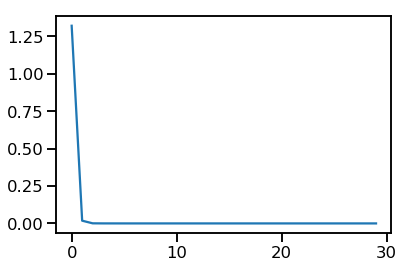

Best epoch: 28


In [36]:
plt.plot(losses)
plt.show()
print('Best epoch: ' + str(losses.index(min(losses)) + 1))

## Evaluation

In [37]:
transformer.eval()
src1 = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]))
src2 = Variable(torch.LongTensor([[1,1,1,3,3,1,1,1,4,1]]))
src3 = Variable(torch.LongTensor([[1,2,3,4,5,6,5,4,3,2]]))
src4 = Variable(torch.LongTensor([[1,2,3,2,1,2,3,2,1,2]]))
src5 = Variable(torch.LongTensor([[1,10,1,10,1,10,1,10,1,10]]))
src_mask = Variable(torch.ones(1, 1, 10) )
print(transformer.greedy_decode(src1, src_mask, max_len=10, start_symbol=1))
print(transformer.greedy_decode(src2, src_mask, max_len=10, start_symbol=1))
print(transformer.greedy_decode(src3, src_mask, max_len=10, start_symbol=1))
print(transformer.greedy_decode(src4, src_mask, max_len=10, start_symbol=1))
print(transformer.greedy_decode(src5, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])
tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])
tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])
tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])
tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])
